# 1 Configuration

## 1.1 Import Libraries

In [1]:
import sys
import pandas as pd
import seaborn as sns
import matplotlib as matplot
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy
import graphviz

print("Python ver: {}".format(sys.version))
print("Numpy ver: {}".format(np.__version__))
print("Pandas ver: {}".format(pd.__version__))
print("MatPlotLib ver: {}".format(matplot.__version__))
print("SeaBorn ver: {}".format(sns.__version__))
print("StatsModel ver: {}".format(sm.__version__))
print("Scipy ver: {}".format(scipy.__version__))
print("SkLearn ver: {}".format(sklearn.__version__))
print("Graphviz ver: {}".format(graphviz.__version__))

Python ver: 3.8.5 (default, Jan 27 2021, 15:41:15) 
[GCC 9.3.0]
Numpy ver: 1.19.5
Pandas ver: 1.1.4
MatPlotLib ver: 3.3.3
SeaBorn ver: 0.11.1
StatsModel ver: 0.12.1
Scipy ver: 1.5.4
SkLearn ver: 0.24.1
Graphviz ver: 0.16


In [2]:
def displayPredictors(df):
    print("Number of predictors: {}".format(len(df.columns.values)))
    for i in range(0,len(df.columns.values)):
        print("{}.'{}'".format(i+1,df.columns.values[i]), end=', ')
        
def heatMap(df,max=1,min=-1,triangleMask=False,showDiameter=True,width=11,height=9):
    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(width, height))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(230, 20, as_cmap=True)

    # Generate a mask for the upper triangle
    if triangleMask:
        if showDiameter :
            mask = np.triu(np.ones_like(df, dtype=bool),1)
        else:
            mask = np.triu(np.ones_like(df, dtype=bool))
    else:
        mask = None
    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(df, mask=mask, cmap=cmap, vmax=max, center=(max+min)/2, vmin=min,
                square=True, annot=True, linewidths=.2, cbar_kws={"shrink": .5})

    # Show the plot
    plt.show()
    
    
def scatterPlot(df,xColumn,yColumn,xLabel,yLabel,width=9,height=6,pearson=False):
    fig, ax = plt.subplots(figsize=(width,height))
    
    sns.regplot(y=yColumn, x=xColumn, data=df,ax=ax)
    
    if xLabel:
        plt.xlabel(xLabel)
    if yLabel:
        plt.ylabel(yLabel)
        
    plt.show()
    
    if pearson:
        r,p = scipy.stats.pearsonr(df[xColumn], df[yColumn])
        print("r = {} , p < {}".format(round(r, 3),p))

def pieChart(values,labels,width=7,height=7):
    f, ax = plt.subplots(figsize=(width, height))
    ax = plt.pie(values, labels=labels, wedgeprops={'edgecolor': 'black'}, autopct='%1.f%%', explode=(values*0)+0.05, shadow=True)
    plt.show()
        
def checkColumnsTypes(df):
    types = pd.DataFrame({"Name":df.columns})
    quantitative = df.dtypes[df.dtypes!="object"]
    qualitative = df.dtypes[df.dtypes=="object"]
    types["Type"] = np.where(df[types['Name']].dtypes!="object", "Quantitative", "Qualitative")
    types["isQuantitative"] = np.where(df[types['Name']].dtypes!="object", True, False)
    return types ,types["Type"].value_counts()
    
def checkCorrectness(df,originalLabel,predictedLabel):
    correct = len(df[(df[originalLabel] == df[predictedLabel])])
    incorrect = len(df) - correct
    return (correct,incorrect,(correct*100/(correct+incorrect)))

def findCorrelatedColumns(df,minThreshold):
    corr = df.corr()
    pairs = []

    for i in corr.columns:
        for j in corr[i][abs(corr[i])>=minThreshold].index:
            if i != j:
                pairs.append({"C1":i,"C2":j,"Corr":corr[i][j]})
    return pairs

def findHighCorrelation(df,minThreshold,target):
    corr = df.corr()
    pairs = []

    for j in corr[target][abs(corr[target])>=minThreshold].index:
        if target != j:
            pairs.append({"Name":j,"Corr":corr[target][j]})
    return pairs

## 1.2 Pre configurations

In [3]:
import warnings

# Set Seaborn theme
sns.set_theme(color_codes=True)

# Disable warnings
warnings.simplefilter("ignore")

# 2 Data Preparation

## 2.1 Load the data

In [4]:
AimoScoreFileUrl = "https://raw.githubusercontent.com/digitacs/4dv652-ml/main/datasets/AimoScore_WeakLink_big_scores.xls"
WeakLinksFileUrl = "https://raw.githubusercontent.com/digitacs/4dv652-ml/main/datasets/20190108%20scores_and_weak_links.xlsx"

try:
    AimoScore = pd.read_excel(AimoScoreFileUrl, engine=None)
    WeakLinks = pd.read_excel(WeakLinksFileUrl, engine='openpyxl')

except IOError as e:
    print(e)


## 2.2 Merging the two datasets

### 2.2.1 Join the two tables via their ID

In [5]:
print("AimoScore size: {}".format(len(AimoScore)))
print("WeakLinks size: {}".format(len(WeakLinks)))
result = pd.merge(AimoScore, WeakLinks,on=["ID"])
print("result size: {}".format(len(result)))

AimoScore size: 2094
WeakLinks size: 2096
result size: 2094


### 2.2.2 Find the weakest link for each data point
Finding the column with the maximum score in each row and adding its name as a new column

In [6]:
result["WeakLinks"] = result.loc[:,"ForwardHead":"RightHeelRises"].idxmax(axis=1)

### 2.2.3 Discard extra columns
Discard the 14 weak link scores from the joint table

In [7]:
result.drop(result.columns.to_series()["ForwardHead":"RightHeelRises"], axis=1, inplace=True)

### 2.2.4 Remove Duplicates

In [8]:
result = result.drop_duplicates(subset="ID")

In [9]:
result["WeakLinks"].value_counts()

LeftArmFallForward              628
RightArmFallForward             472
RightKneeMovesOutward           276
RightShoulderElevation          250
ForwardHead                     115
ExcessiveForwardLean            100
LeftAsymmetricalWeightShift      73
LeftShoulderElevation            58
LeftKneeMovesOutward             49
RightKneeMovesInward             45
RightAsymmetricalWeightShift     19
LeftKneeMovesInward               3
LeftHeelRises                     2
RightHeelRises                    1
Name: WeakLinks, dtype: int64

### 2.2.5 Remove clusters with very few samples 

In [10]:
temp = (result["WeakLinks"].value_counts()<10)
temp = temp[~temp == False]
result = result[~result["WeakLinks"].isin(temp.index)]
result["WeakLinks"].value_counts()

LeftArmFallForward              628
RightArmFallForward             472
RightKneeMovesOutward           276
RightShoulderElevation          250
ForwardHead                     115
ExcessiveForwardLean            100
LeftAsymmetricalWeightShift      73
LeftShoulderElevation            58
LeftKneeMovesOutward             49
RightKneeMovesInward             45
RightAsymmetricalWeightShift     19
Name: WeakLinks, dtype: int64

In [11]:
result[["ID","SCORE","AimoScore","WeakLinks"]]

,ID,SCORE,AimoScore,WeakLinks
0,0003cdcc-86ed-494a-a3b5-90d09e96e06b.Kinect,0.323667,0.323667,RightShoulderElevation
1,003115c4-bdb8-491c-b571-8fcebdecf8ed.Kinect,0.323699,0.323699,RightArmFallForward
2,00316bfb-ed43-489f-a55b-11c7f01c852d.Kinect,0.848327,0.848327,LeftArmFallForward
3,00607608-6f2f-459b-a69d-e14067489459.Kinect,0.351332,0.351332,RightShoulderElevation
4,007396ec-3463-4a05-915c-02244ff8d3de.Kinect,0.627181,0.627181,ForwardHead
...,...,...,...,...
2086,feca4c0e-cbc7-4e5e-b85c-8befedbc65a4.Kinect,0.665494,0.665494,RightArmFallForward
2087,fed923af-f41e-42bc-8799-3a9f8a5f2129.Kinect,0.830883,0.830883,LeftArmFallForward
2088,ff015ddd-c9fb-49e3-8e33-abbf72e8b120.Kinect,0.527640,0.527640,LeftArmFallForward
2090,ff514cba-6c5e-41a9-9936-3e8400565c8d.Kinect,0.407197,0.407197,RightKneeMovesOutward


## 2.3 Removing the identical variables

In [12]:
pairs = findCorrelatedColumns(result,1)
pairs

[{'C1': 'AimoScore', 'C2': 'SCORE', 'Corr': 1.0},
 {'C1': 'No_1_Angle_Deviation', 'C2': 'No_3_NASM_Deviation', 'Corr': 1.0},
 {'C1': 'No_5_Angle_Deviation', 'C2': 'No_1_NASM_Deviation', 'Corr': 1.0},
 {'C1': 'No_7_Angle_Deviation', 'C2': 'No_2_NASM_Deviation', 'Corr': 1.0},
 {'C1': 'No_10_Angle_Deviation', 'C2': 'No_4_NASM_Deviation', 'Corr': 1.0},
 {'C1': 'No_13_Angle_Deviation', 'C2': 'No_5_NASM_Deviation', 'Corr': 1.0},
 {'C1': 'No_1_NASM_Deviation', 'C2': 'No_5_Angle_Deviation', 'Corr': 1.0},
 {'C1': 'No_2_NASM_Deviation', 'C2': 'No_7_Angle_Deviation', 'Corr': 1.0},
 {'C1': 'No_3_NASM_Deviation', 'C2': 'No_1_Angle_Deviation', 'Corr': 1.0},
 {'C1': 'No_4_NASM_Deviation', 'C2': 'No_10_Angle_Deviation', 'Corr': 1.0},
 {'C1': 'No_5_NASM_Deviation', 'C2': 'No_13_Angle_Deviation', 'Corr': 1.0},
 {'C1': 'SCORE', 'C2': 'AimoScore', 'Corr': 1.0}]

In [13]:
result = result.drop(
    columns=[
        "No_1_Angle_Deviation",
        "No_5_Angle_Deviation",
        "No_7_Angle_Deviation",
        "No_10_Angle_Deviation",
        "No_13_Angle_Deviation",
        "SCORE"
    ]
)

## 2.4 Removing the symmetric variables 
We assume that any variable with a correlation higher than 80 percent would be a symmetric variable

In [14]:
pairs = findCorrelatedColumns(result,0.8)
pairs

[{'C1': 'No_1_NASM_Deviation',
  'C2': 'No_2_NASM_Deviation',
  'Corr': 0.8491413141954607},
 {'C1': 'No_2_NASM_Deviation',
  'C2': 'No_1_NASM_Deviation',
  'Corr': 0.8491413141954607},
 {'C1': 'No_4_NASM_Deviation',
  'C2': 'No_5_NASM_Deviation',
  'Corr': 0.904593644698089},
 {'C1': 'No_5_NASM_Deviation',
  'C2': 'No_4_NASM_Deviation',
  'Corr': 0.904593644698089},
 {'C1': 'No_8_NASM_Deviation',
  'C2': 'No_9_NASM_Deviation',
  'Corr': 0.8742235883032127},
 {'C1': 'No_9_NASM_Deviation',
  'C2': 'No_8_NASM_Deviation',
  'Corr': 0.8742235883032127},
 {'C1': 'No_11_NASM_Deviation',
  'C2': 'No_12_NASM_Deviation',
  'Corr': 0.8645293700913619},
 {'C1': 'No_12_NASM_Deviation',
  'C2': 'No_11_NASM_Deviation',
  'Corr': 0.8645293700913619},
 {'C1': 'No_1_Time_Deviation',
  'C2': 'No_2_Time_Deviation',
  'Corr': 0.9390442066679106},
 {'C1': 'No_2_Time_Deviation',
  'C2': 'No_1_Time_Deviation',
  'Corr': 0.9390442066679106}]

In [15]:
result = result.drop(
    columns=[
        "No_1_NASM_Deviation",
        "No_5_NASM_Deviation",
        "No_9_NASM_Deviation",
        "No_11_NASM_Deviation",
        "No_2_Time_Deviation"
    ]
)

## 2.5 Discard extra columns

In [16]:
result = result.drop(
    columns=[
        "ID",
        "Date",
        "EstimatedScore"
    ]
)

### Testing and Traing sets

In [17]:
from sklearn.model_selection import train_test_split

trainingPercent = 0.7

y_train,y_test ,X_train, X_test  = train_test_split(result["AimoScore"], result.drop(columns=["WeakLinks","AimoScore"]), train_size = trainingPercent)

# 3 Create the models

## 3.1 Regression Trees

In [18]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error


tree_5 = DecisionTreeRegressor(max_depth=3,random_state= 42)
tree_5.fit(X_train, y_train)
tree_5.score(X_test, y_test)
pred_5 = tree_5.predict(X_test)

print(mean_squared_error(y_test,pred_5))

0.03055270539383767


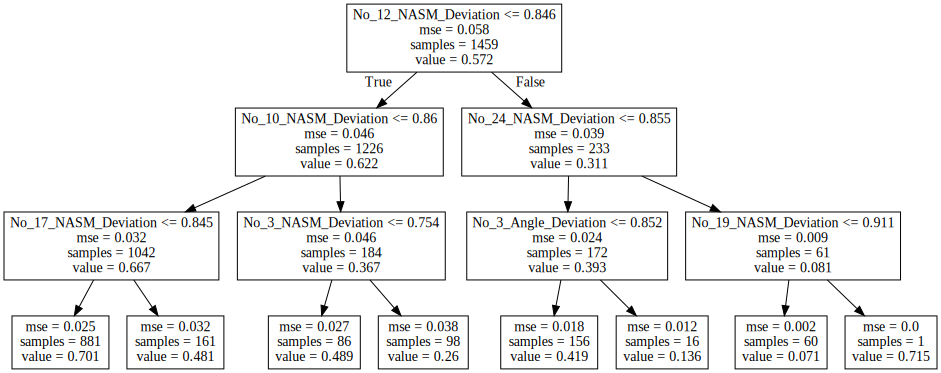

In [19]:
from sklearn.tree import export_graphviz

export_graphviz(tree_5, 
                out_file = "carseat_tree.dot", 
                feature_names = X_train.columns)

with open("carseat_tree.dot") as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)

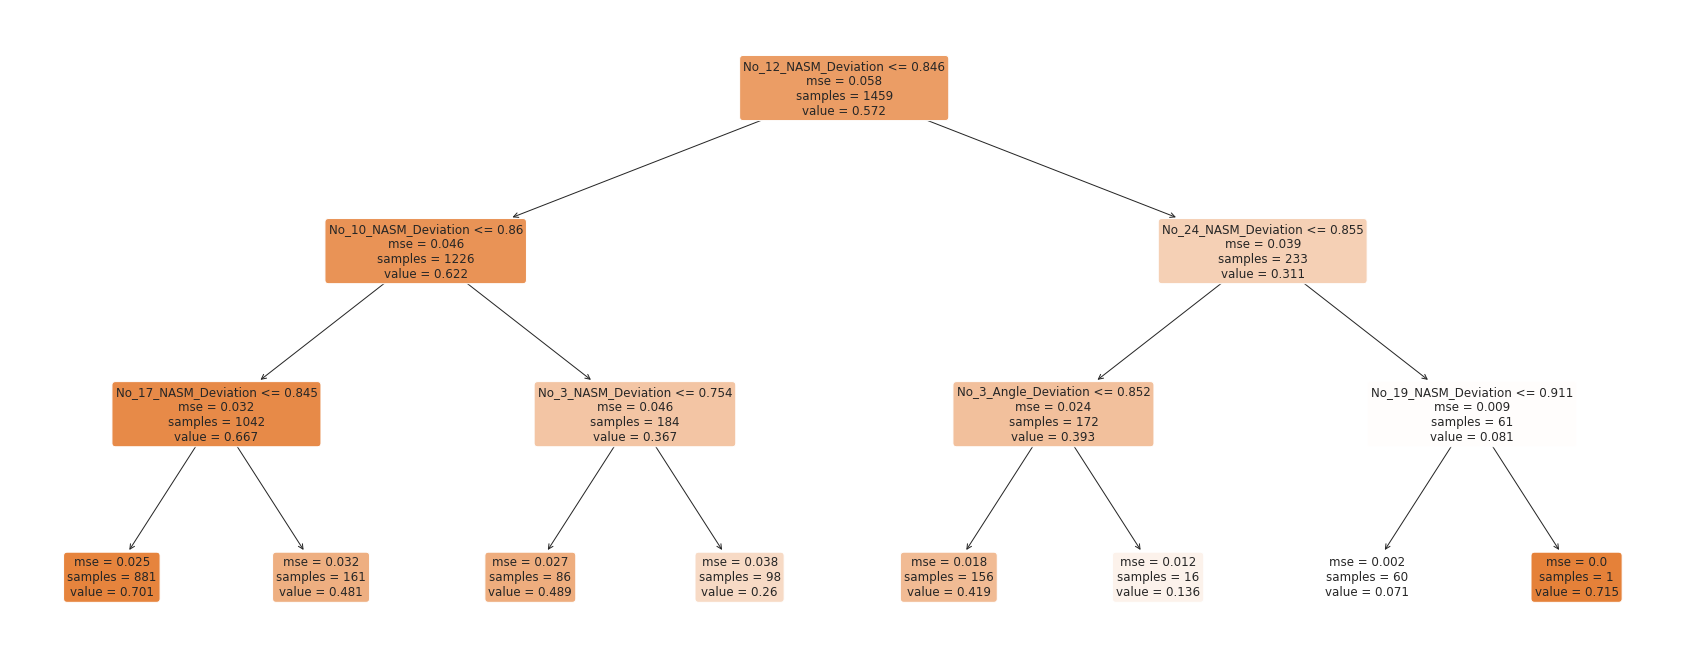

In [20]:
from sklearn.tree import plot_tree

plt.figure(figsize=(30, 12))
plot_tree(tree_5, feature_names=X_train.columns, 
          filled=True, rounded=True);

In [77]:
from sklearn.model_selection import cross_val_score,KFold
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor


def crossValidationOnTreeRegressor(X, y,minDepths, maxDepths, cv=5, scoring='neg_mean_squared_error',random_state= 42):
    kfolds = KFold(n_splits = cv, shuffle = True, random_state = random_state)
    scores = []
    stds = []
    means = []
    mses = []
    
    for depth in range(minDepths,maxDepths+1):
        tree = DecisionTreeRegressor(max_depth=depth,random_state=random_state)
        cvs = abs(cross_val_score(tree, X, y, cv=kfolds, scoring=scoring))
        scores.append(cvs)
        means.append(cvs.mean())
        stds.append(cvs.std())
        mses.append(tree.fit(X, y).score(X, y))
        
    means = np.array(means)
    stds = np.array(stds)
    mses = np.array(mses)
    return means, stds, mses

def crossValidationOnRandomForestRegressor(X, y,min_features,max_features, cv=5, scoring='neg_mean_squared_error',random_state= 42):
    kfolds = KFold(n_splits = cv, shuffle = True, random_state = random_state)
    scores = []
    stds = []
    means = []
    mses = []
    
    for features in range(min_features,max_features+1):
        tree = RandomForestRegressor(max_features=features,random_state=random_state)
        cvs = abs(cross_val_score(tree, X, y, cv=kfolds, scoring=scoring))
        scores.append(cvs)
        means.append(cvs.mean())
        stds.append(cvs.std())
        mses.append(tree.fit(X, y).score(X, y))
        
    means = np.array(means)
    stds = np.array(stds)
    mses = np.array(mses)
    return means, stds, mses

def crossValidationOnGradientBoostingRegressor(X, y,minDepths, maxDepths, cv=5,
                                               scoring='neg_mean_squared_error',
                                               random_state= 42,n_estimators=100):
    kfolds = KFold(n_splits = cv, shuffle = True, random_state = random_state)
    scores = []
    stds = []
    means = []
    mses = []
    
    for depth in range(minDepths,maxDepths+1):
        tree = GradientBoostingRegressor(n_estimators=n_estimators,max_depth=depth,random_state=random_state)
        cvs = abs(cross_val_score(tree, X, y, cv=kfolds, scoring=scoring))
        scores.append(cvs)
        means.append(cvs.mean())
        stds.append(cvs.std())
        mses.append(tree.fit(X, y).score(X, y))
        
    means = np.array(means)
    stds = np.array(stds)
    mses = np.array(mses)
    return means, stds, mses

def crossValidationOnGradientBoostingRegressorWithRate(X, y,maxDepths, learningRateFrom, learningRateTo, cv=5,
                                               scoring='neg_mean_squared_error',
                                               random_state= 42,n_estimators=100):
    kfolds = KFold(n_splits = cv, shuffle = True, random_state = random_state)
    scores = []
    stds = []
    means = []
    mses = []
    
    for rate in range(learningRateFrom,learningRateTo+1):
        tree = GradientBoostingRegressor(n_estimators=n_estimators,max_depth=maxDepths,random_state=random_state,learning_rate=rate/100)
        cvs = abs(cross_val_score(tree, X, y, cv=kfolds, scoring=scoring))
        scores.append(cvs)
        means.append(cvs.mean())
        stds.append(cvs.std())
        mses.append(tree.fit(X, y).score(X, y))
        
    means = np.array(means)
    stds = np.array(stds)
    mses = np.array(mses)
    return means, stds, mses

def crossValidationPlotOnTree(minDepths,maxDepths, cv_means, cv_stds, cv_mse, title,xLabel="Tree depth",yLabel="Mean Squared Error"):
    depths = range(minDepths,maxDepths+1)
    fig, ax = plt.subplots(1,1, figsize=(15,5))
    ax.plot(depths, cv_means, '-o', label='mean cross-validation mse', alpha=0.9)
    ax.fill_between(depths, cv_means-2*cv_stds, cv_means+2*cv_stds, alpha=0.2)
    ylim = plt.ylim()
    ax.plot(depths, cv_mse, '-*', label='train mse', alpha=0.9)
    ax.set_title(title, fontsize=16)
    ax.set_xlabel(xLabel, fontsize=14)
    ax.set_ylabel(yLabel, fontsize=14)
    ax.set_ylim(ylim)
    ax.set_xticks(depths)
    ax.legend()

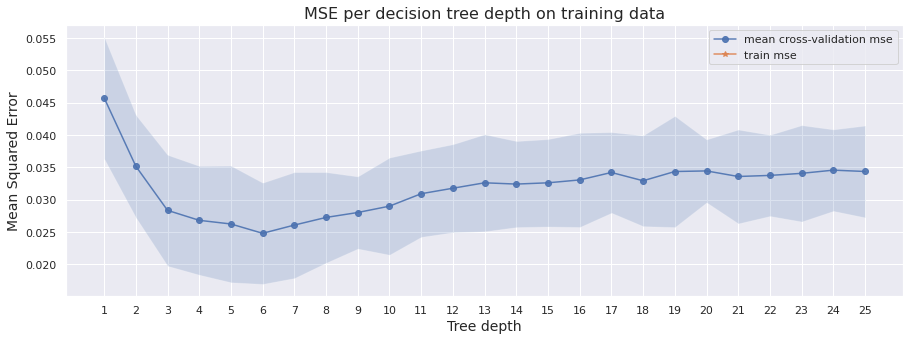

In [58]:
x = result.drop(["WeakLinks","AimoScore"], axis = 1)
y = result["AimoScore"]


cv_means, cv_stds, cv_mse = crossValidationOnTreeRegressor(x,y,minDepths=1,maxDepths=25, cv=10)
crossValidationPlotOnTree(1,25, cv_means, cv_stds, cv_mse,'MSE per decision tree depth on training data',xLabel="Tree depth",yLabel="Mean Squared Error")

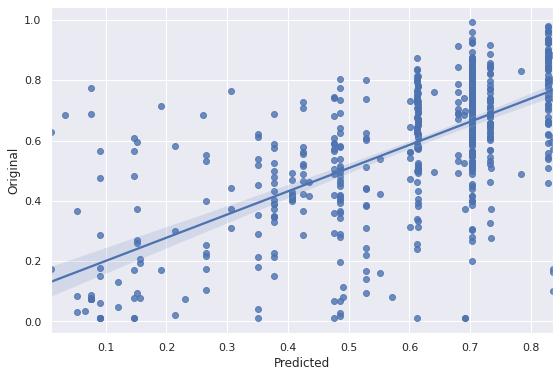

r = 0.666 , p < 1.7488142447920468e-81
MSE:  0.031193276409339592


In [59]:
tree_1 = DecisionTreeRegressor(max_depth=6,random_state= 42)
tree_1.fit(X_train, y_train)
tree_1.score(X_test, y_test)
pred_1 = tree_1.predict(X_test)

res = pd.DataFrame({"Original":y_test,"Predicted":pred_1})

fig, ax = plt.subplots(figsize=(9,6))
sns.regplot(y="Original", x="Predicted", data=res,ax=ax)
plt.xlabel("Predicted")
plt.ylabel("Original")
plt.show()
r,p = scipy.stats.pearsonr(res.Predicted, res.Original)
print("r = {} , p < {}".format(round(r, 3),p))
print("MSE: ",np.mean((pred_1-y_test)**2))

## 3.2 Regression Bagging (Trees) and Random Forests

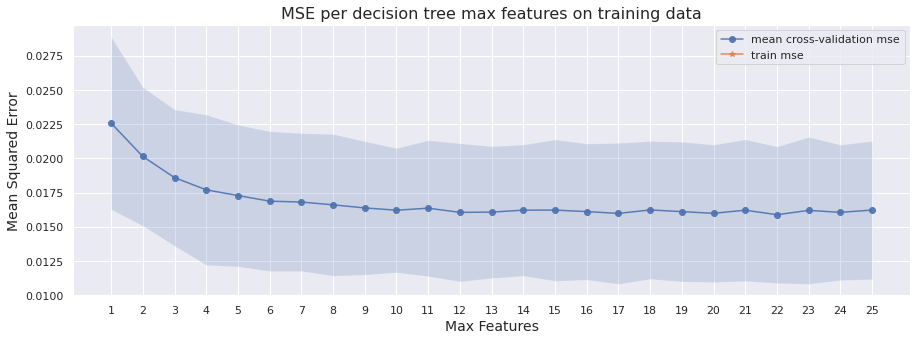

In [63]:
x = result.drop(["WeakLinks","AimoScore"], axis = 1)
y = result["AimoScore"]


cv_means, cv_stds, cv_mse = crossValidationOnRandomForestRegressor(x,y,min_features=1,max_features=25, cv=10)
crossValidationPlotOnTree(1,25, cv_means, cv_stds, cv_mse,'MSE per decision tree max features on training data',xLabel="Max Features",yLabel="Mean Squared Error")

In [85]:
from sklearn.ensemble import RandomForestRegressor

baged_1 = RandomForestRegressor()
baged_1.fit(X_train, y_train)

RandomForestRegressor()

R-squared:  0.6675185254787818
MSE:  0.01733957802465676


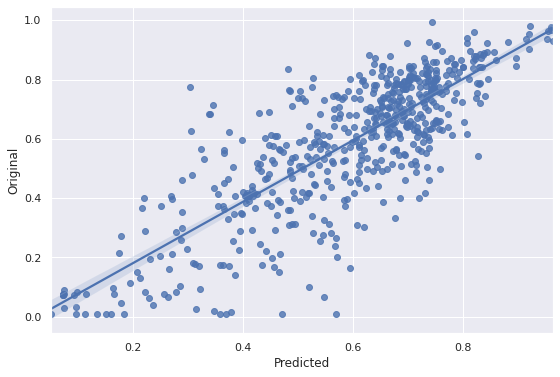

In [86]:
pred_baged_1 = baged_1.predict(X_test)

print("R-squared: ",baged_1.score(X_test, y_test))
print("MSE: ",mean_squared_error(y_test, pred_baged_1))

res = pd.DataFrame({"Original":y_test,"Predicted":pred_baged_1})

fig, ax = plt.subplots(figsize=(9,6))
sns.regplot(y="Original", x="Predicted", data=res,ax=ax)
plt.xlabel("Predicted")
plt.ylabel("Original")
plt.show()

R-squared:  0.6837961121544259
MSE:  0.016490669120418147


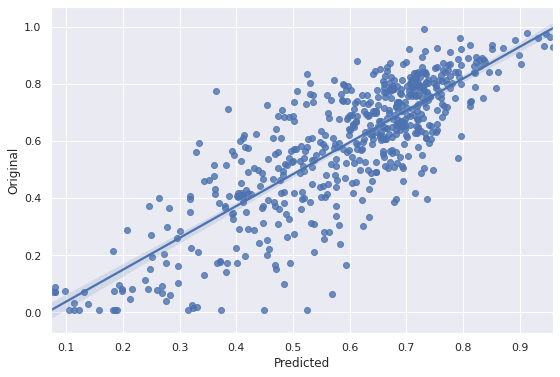

In [87]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

randomForest = RandomForestRegressor(max_features = 12, random_state = 1)
randomForest.fit(X_train, y_train)

print("R-squared: ",randomForest.score(X_test, y_test))

pred_baged_3 = randomForest.predict(X_test)

print("MSE: ",mean_squared_error(y_test, pred_baged_3))

res = pd.DataFrame({"Original":y_test,"Predicted":pred_baged_3})

fig, ax = plt.subplots(figsize=(9,6))
sns.regplot(y="Original", x="Predicted", data=res,ax=ax)
plt.xlabel("Predicted")
plt.ylabel("Original")
plt.show()

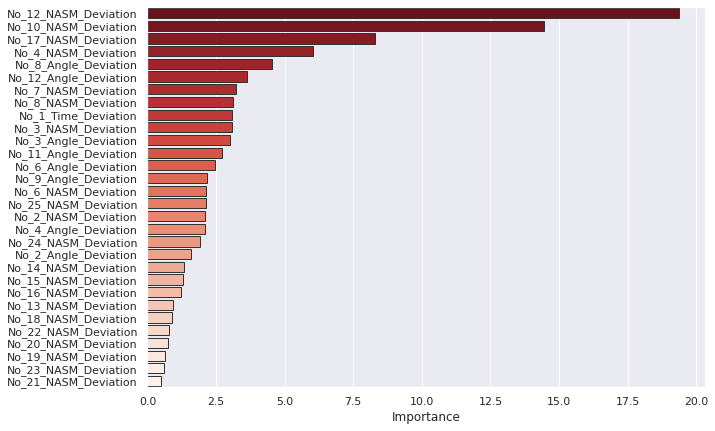

,Importance
No_12_NASM_Deviation,19.365576
No_10_NASM_Deviation,14.432613
No_17_NASM_Deviation,8.278937
No_4_NASM_Deviation,6.048645
No_8_Angle_Deviation,4.544366
No_12_Angle_Deviation,3.634679
No_7_NASM_Deviation,3.226786
No_8_NASM_Deviation,3.110912
No_1_Time_Deviation,3.092450
No_3_NASM_Deviation,3.091693


In [28]:
importance = pd.DataFrame({'Importance':randomForest.feature_importances_*100}, 
                          index = X_train.columns)

importance =importance.sort_values(by = 'Importance',axis = 0,ascending = False)

f, ax = plt.subplots(figsize=(10, 7))
ax = sns.barplot(x="Importance", y=importance["Importance"].index, data=importance,
                 linewidth=1, palette="Reds_r",errcolor=".2", edgecolor=".2")
plt.show()

importance

## 3.3 Regression Boosting (Trees)


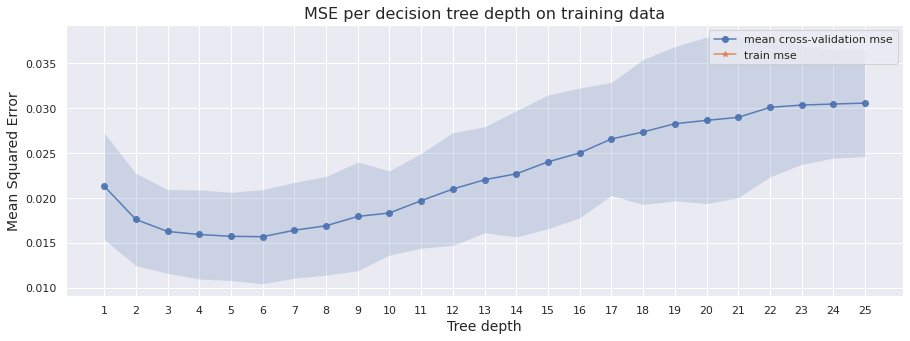

In [29]:
x = result.drop(["WeakLinks","AimoScore"], axis = 1)
y = result["AimoScore"]

cv_means, cv_stds, cv_mse = crossValidationOnGradientBoostingRegressor(x,y,minDepths=1,maxDepths=25, cv=10)
crossValidationPlotOnTree(1,25, cv_means, cv_stds, cv_mse,'MSE per decision tree depth on training data')

In [51]:
from sklearn.ensemble import GradientBoostingRegressor

boostedBoston_1 = GradientBoostingRegressor(n_estimators = 5000,max_depth = 6,random_state = 1)

boostedBoston_1.fit(X_train, y_train)
pred_boosted_1 = boostedBoston_1.predict(X_test)

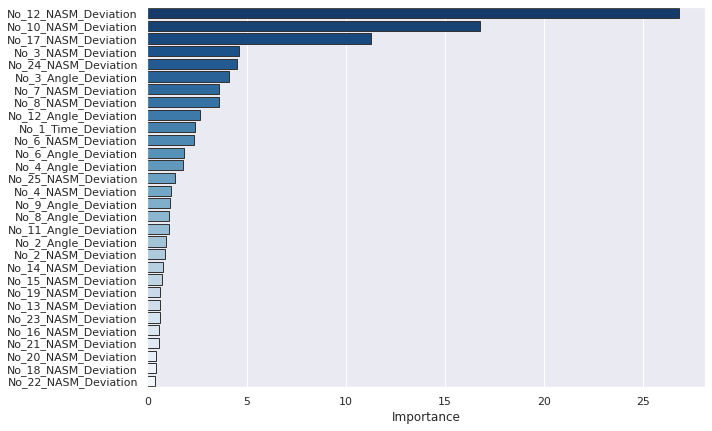

,Importance
No_12_NASM_Deviation,26.809241
No_10_NASM_Deviation,16.766211
No_17_NASM_Deviation,11.287045
No_3_NASM_Deviation,4.620451
No_24_NASM_Deviation,4.517980
No_3_Angle_Deviation,4.110948
No_7_NASM_Deviation,3.616598
No_8_NASM_Deviation,3.593062
No_12_Angle_Deviation,2.657030
No_1_Time_Deviation,2.410304


In [52]:
importance = pd.DataFrame({'Importance':boostedBoston_1.feature_importances_*100}, 
                          index = X_train.columns)

importance =importance.sort_values(by = 'Importance',axis = 0,ascending = False)

f, ax = plt.subplots(figsize=(10, 7))
ax = sns.barplot(x="Importance", y=importance["Importance"].index, data=importance,
                 linewidth=1, palette="Blues_r",errcolor=".2", edgecolor=".2")
plt.show()

importance

In [53]:
pred_boosted_1 = boostedBoston_1.predict(X_test)
mean_squared_error(y_test, pred_boosted_1)

0.017567714319854467

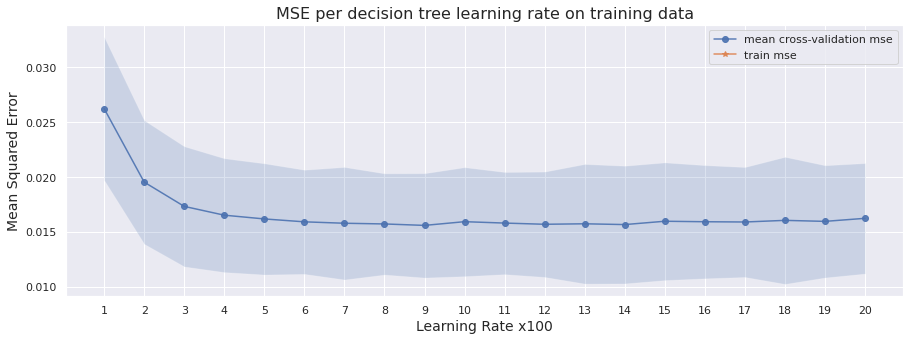

In [81]:
x = result.drop(["WeakLinks","AimoScore"], axis = 1)
y = result["AimoScore"]

cv_means, cv_stds, cv_mse = crossValidationOnGradientBoostingRegressorWithRate(x,y,
                                                                               learningRateFrom=1, 
                                                                               learningRateTo=20,
                                                                               maxDepths=4, cv=10)
crossValidationPlotOnTree(1,20, cv_means, cv_stds, cv_mse,'MSE per decision tree learning rate on training data'
                          ,xLabel="Learning Rate x100",yLabel="Mean Squared Error")

In [95]:
boostedBoston_2 = GradientBoostingRegressor(n_estimators = 500, learning_rate = 0.09, 
                                            max_depth = 4, random_state = 1)
boostedBoston_2.fit(X_train, y_train)

pred_boosted_2 = boostedBoston_2.predict(X_test)
mean_squared_error(y_test, pred_boosted_2)

0.017002513327486885

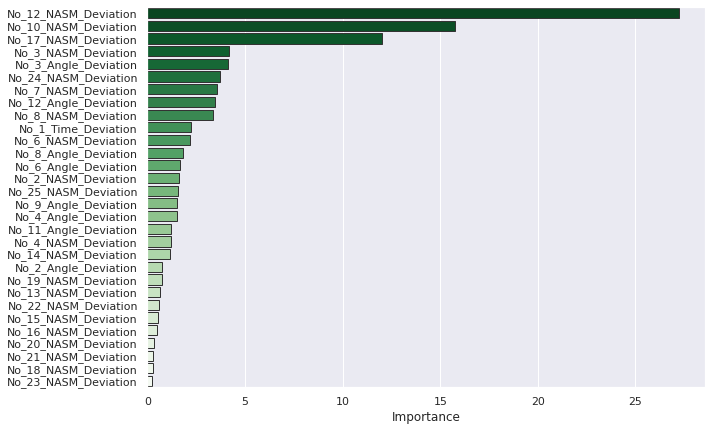

,Importance
No_12_NASM_Deviation,27.223376
No_10_NASM_Deviation,15.764338
No_17_NASM_Deviation,11.998844
No_3_NASM_Deviation,4.158453
No_3_Angle_Deviation,4.148807
No_24_NASM_Deviation,3.715114
No_7_NASM_Deviation,3.561695
No_12_Angle_Deviation,3.479498
No_8_NASM_Deviation,3.372767
No_1_Time_Deviation,2.246806


In [96]:
importance = pd.DataFrame({'Importance':boostedBoston_2.feature_importances_*100}, 
                          index = X_train.columns)

importance =importance.sort_values(by = 'Importance',axis = 0,ascending = False)

f, ax = plt.subplots(figsize=(10, 7))
ax = sns.barplot(x="Importance", y=importance["Importance"].index, data=importance,
                 linewidth=1, palette="Greens_r",errcolor=".2", edgecolor=".2")
plt.show()

importance

## 3.4 The original model

In [35]:
def createExtraPredictors(df):
    X_3 = df.drop(columns=[])
    X_3["A4*N12"] = X_3["No_4_Angle_Deviation"] * X_3["No_12_NASM_Deviation"]
    X_3["A8*N12"] = X_3["No_8_Angle_Deviation"] * X_3["No_12_NASM_Deviation"]
    X_3["N2*N20"] = X_3["No_2_NASM_Deviation"] * X_3["No_20_NASM_Deviation"]
    X_3["N12*N13"] = X_3["No_12_NASM_Deviation"] * X_3["No_13_NASM_Deviation"]
    X_3["N12*N15"] = X_3["No_12_NASM_Deviation"] * X_3["No_15_NASM_Deviation"]
    X_3["N12*N16"] = X_3["No_12_NASM_Deviation"] * X_3["No_16_NASM_Deviation"]
    X_3["N12*N20"] = X_3["No_12_NASM_Deviation"] * X_3["No_20_NASM_Deviation"]
    X_3["N12*N20*N22"] = X_3["No_12_NASM_Deviation"] * X_3["No_20_NASM_Deviation"] * X_3["No_22_NASM_Deviation"]
    X_3["N12*N20*N19"] = X_3["No_12_NASM_Deviation"] * X_3["No_20_NASM_Deviation"] * X_3["No_19_NASM_Deviation"]
    X_3["N12*N20*N19*N16"] = X_3["No_12_NASM_Deviation"] * X_3["No_20_NASM_Deviation"] * X_3["No_19_NASM_Deviation"]* X_3["No_16_NASM_Deviation"]
    X_3["N12*N23"] = X_3["No_12_NASM_Deviation"] * X_3["No_23_NASM_Deviation"]
    X_3["N21*N24"] = X_3["No_21_NASM_Deviation"] * X_3["No_24_NASM_Deviation"]
    X_3["T1*N13"] = X_3["No_1_Time_Deviation"] * X_3["No_13_NASM_Deviation"]
    X_3["T1*N2"] = X_3["No_1_Time_Deviation"] * X_3["No_2_Angle_Deviation"]
    X_3["T1*N18"] = X_3["No_1_Time_Deviation"] * X_3["No_18_NASM_Deviation"]
    X_3["N4*N10*N12"] = X_3["No_4_NASM_Deviation"] * X_3["No_10_NASM_Deviation"] * X_3["No_12_NASM_Deviation"]
    X_3["N8*N12"] = X_3["No_8_Angle_Deviation"] * X_3["No_12_NASM_Deviation"]
    X_3["N4*N10*N12*N15"] = X_3["No_4_NASM_Deviation"] * X_3["No_10_NASM_Deviation"] * X_3["No_12_NASM_Deviation"] * X_3["No_15_NASM_Deviation"]
    X_3["A11*N12"] = X_3["No_11_Angle_Deviation"] * X_3["No_12_NASM_Deviation"]
    X_3["N8*N15"] = X_3["No_8_NASM_Deviation"] * X_3["No_15_NASM_Deviation"]
    X_3["N15*N20"] = X_3["No_15_NASM_Deviation"] * X_3["No_20_NASM_Deviation"]
    X_3["N14*N15*N20*N21"] = X_3["No_14_NASM_Deviation"] *X_3["No_15_NASM_Deviation"] * X_3["No_20_NASM_Deviation"] * X_3["No_21_NASM_Deviation"]
    X_3["N4*N10"] = X_3["No_4_NASM_Deviation"] * X_3["No_10_NASM_Deviation"]
    X_3["N4**2"] = X_3["No_4_NASM_Deviation"] ** 2
    X_3["N8**2"] = X_3["No_8_NASM_Deviation"] ** 2
    X_3["N10**2"] = X_3["No_10_NASM_Deviation"] ** 2
    X_3["N10**3"] = X_3["No_10_NASM_Deviation"] ** 3
    X_3["N8**"] = X_3["No_8_NASM_Deviation"] ** 3
    X_3["N8**4"] = X_3["No_8_NASM_Deviation"] ** 4
    X_3["N8**5"] = X_3["No_8_NASM_Deviation"] ** 5
    X_3["N4*N14"] = X_3["No_4_NASM_Deviation"] * X_3["No_14_NASM_Deviation"]
    X_3["N20*N24"] = X_3["No_20_NASM_Deviation"] * X_3["No_24_NASM_Deviation"]
    X_3["N21*N23"] = X_3["No_21_NASM_Deviation"] * X_3["No_23_NASM_Deviation"]
    X_3["T1*N21*N23"] = X_3["No_1_Time_Deviation"] * X_3["N21*N23"]
    X_3["T1*N21*N23*N12"] = X_3["No_1_Time_Deviation"] * X_3["N21*N23"] * X_3["No_12_NASM_Deviation"]
    X_3["T1*N21*N23*N2*N4"] = X_3["No_1_Time_Deviation"] * X_3["N21*N23"]*X_3["No_2_NASM_Deviation"] * X_3["No_4_NASM_Deviation"]
    X_3["N20*N16"] = X_3["No_20_NASM_Deviation"] * X_3["No_16_NASM_Deviation"]
    X_3["N20*N16*N19"] = X_3["No_20_NASM_Deviation"] * X_3["No_16_NASM_Deviation"] * X_3["No_19_NASM_Deviation"]
    X_3["N12*N6"] = X_3["No_12_NASM_Deviation"] * X_3["No_6_NASM_Deviation"]
    X_3["N12*N7"] = X_3["No_12_NASM_Deviation"] * X_3["No_7_NASM_Deviation"]
    X_3["N12**2"] = X_3["No_12_NASM_Deviation"] ** 2
    X_3["N12**3"] = X_3["No_12_NASM_Deviation"] ** 3
    X_3["N12**4"] = X_3["No_12_NASM_Deviation"] ** 4
    X_3["N12**5"] = X_3["No_12_NASM_Deviation"] ** 5
    X_3["N12**6"] = X_3["No_12_NASM_Deviation"] ** 6
    X_3["N15**3"] = X_3["No_15_NASM_Deviation"] **3
    X_3["N20**3"] = X_3["No_20_NASM_Deviation"] **3

    return X_3.drop(columns=[
        "No_4_Angle_Deviation",
        "No_14_NASM_Deviation",
        "No_4_NASM_Deviation",
        "No_21_NASM_Deviation",
        "No_24_NASM_Deviation",
        "No_25_NASM_Deviation",
        "No_10_NASM_Deviation",
        "No_13_NASM_Deviation"
    ])

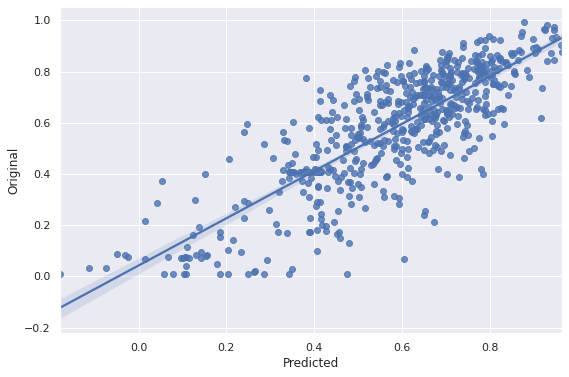

r = 0.816 , p < 1.7010767541472206e-150


In [36]:
X_2 = createExtraPredictors(X_train)

t = sm.add_constant(X_2, prepend=False)
model = sm.OLS(y_train,t).fit()

X_3 = createExtraPredictors(X_test)

t1 = sm.add_constant(X_3, prepend=False)
predicted_2 = model.predict(t1)

res = pd.DataFrame({"Original":y_test,"Predicted":predicted_2})

fig, ax = plt.subplots(figsize=(9,6))
sns.regplot(y="Original", x="Predicted", data=res,ax=ax)
plt.xlabel("Predicted")
plt.ylabel("Original")
plt.show()
r,p = scipy.stats.pearsonr(res.Predicted, res.Original)
print("r = {} , p < {}".format(round(r, 3),p))

## 3.5 The Second Linear Model

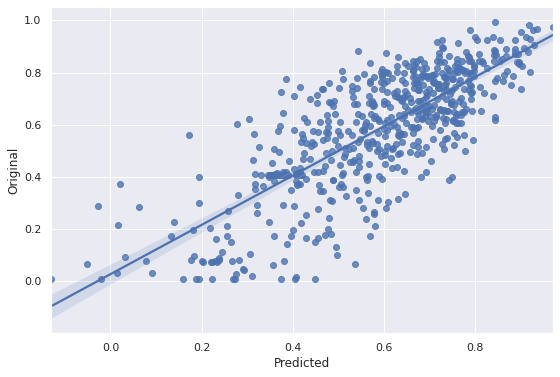

r = 0.788 , p < 1.40606381767247e-133


In [91]:
X_2 = X_train.drop(columns=[])
X_2["No_12_NASM_Deviation ^ 2"] = X_2["No_12_NASM_Deviation"] ** 2
X_2["No_10_NASM_Deviation ^ 2"] = X_2["No_10_NASM_Deviation"] ** 2
X_2["No_17_NASM_Deviation ^ 2"] = X_2["No_17_NASM_Deviation"] ** 2

t = sm.add_constant(X_2, prepend=False)
model = sm.OLS(y_train,t).fit()

X_3 = X_test.drop(columns=[])
X_3["No_12_NASM_Deviation ^ 2"] = X_3["No_12_NASM_Deviation"] ** 2
X_3["No_10_NASM_Deviation ^ 2"] = X_3["No_10_NASM_Deviation"] ** 2
X_3["No_17_NASM_Deviation ^ 2"] = X_3["No_17_NASM_Deviation"] ** 2

t1 = sm.add_constant(X_3, prepend=False)
predicted_3 = model.predict(t1)

res = pd.DataFrame({"Original":y_test,"Predicted":predicted_3})

fig, ax = plt.subplots(figsize=(9,6))
sns.regplot(y="Original", x="Predicted", data=res,ax=ax)
plt.xlabel("Predicted")
plt.ylabel("Original")
plt.show()
r,p = scipy.stats.pearsonr(res.Predicted, res.Original)
print("r = {} , p < {}".format(round(r, 3),p))

## 3.4 Comparison

### 3.4.1 Comparing the MSRs 

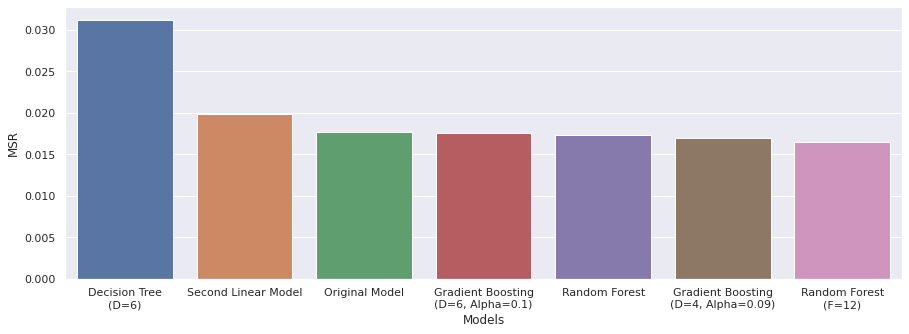

In [104]:
from sklearn.metrics import mean_squared_error

mse_1 = mean_squared_error(y_test, predicted_2)
mse_2 = mean_squared_error(y_test, predicted_3)
mse_3 = mean_squared_error(y_test, pred_1)
mse_4 = mean_squared_error(y_test, pred_baged_1)
mse_5 = mean_squared_error(y_test, pred_baged_3)
mse_6 = mean_squared_error(y_test, pred_boosted_1)
mse_7 = mean_squared_error(y_test, pred_boosted_2)


results = pd.DataFrame({
    "MSR":[mse_1,mse_2,mse_3,mse_4,mse_5,mse_6,mse_7],
    "Models":["Original Model","Second Linear Model","Decision Tree\n(D=6)",
              "Random Forest","Random Forest\n(F=12)","Gradient Boosting\n(D=6, Alpha=0.1)","Gradient Boosting\n(D=4, Alpha=0.09)"]})

results = results.sort_values("MSR", ascending=False)

# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(15,5))

sns.barplot(data=results, x="Models", y="MSR",ax=ax)

# Add labels to plot
plt.xlabel("Models")
plt.ylabel("MSR")

plt.show()



Considering the models comparison, the Bagged model (Random forest with maximum 12 features) will be the new champion